In [21]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [22]:
# read in all the words
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [23]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [24]:
# build the dataset
# block size is the context length: how many chars do we take to predict the next one
def build_dataset(words):
    block_size = 3 
    x, y =[],[]
    for w in words:
        #print(w)
        context = [0] * block_size # initializing the block with ... padding
        for ch in w + '.': #to mark the ending of a word
            ix = stoi[ch]
            x.append(context) # this is where it is intially padded with dots....
            y.append(ix) # index of the next character
            #print(''.join(itos[i] for i in context),'---->',itos[ix])
            context = context[1:] + [ix] #crop and append the character for next iteration(decrease the padded dots)
        
    x = torch.tensor(x)
    y = torch.tensor(y)
    print(x.shape,y.shape)
    return x,y
#print(x[1,:])
#print(y[1])
#from the above print example you can see that X is a possible context
#before the next character which is y
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

xtr, ytr = build_dataset(words[:n1])
xdev, ydev = build_dataset(words[n1:n2])
xte, yte = build_dataset(words[n2:])
block_size = 3

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [44]:
n_emb = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the numbe rof neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
c = torch.rand((27,n_emb),generator=g)
# hidden layer
w1 = torch.randn((n_emb*block_size,n_hidden),generator=g) * 0.2
b1 = torch.randn(n_hidden,generator=g) * 0.01
# we are multipliying w1 abd b1 by small numbers so that we are able to avoid the saturation of the tanh(hidden layer)
# if the values of b1 and w1 are too high, the value of hpreact will be too much
# therefore most of the values of coming out of h will be close to 1 and -1 
# which means, (accroding to the formula and graph of tanh), there will not be any learning 
# because it is in the flat zone of tanh and the gradient is close to 0.
# final layer
w2 = torch.randn((n_hidden,27),generator=g) * 0.01
b2 = torch.randn(27,generator=g) * 0

# notice how we are multipliying w2 by 0.01 and b2 by 0
# it is because we want to initialize the model logits with values close to 0
# which will give us a first loss which makes much more sense and close to the real loss
# we want the count(logits) to be uniform intially because
# we assume all letters have same probability of occuring in the first run

parameters = [c, w1, b1, w2, b2]
for p in parameters:
    p.requires_grad =  True

In [45]:
sum(p.nelement() for p in parameters)  # number of parameters in total

11897

In [46]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre
lossi = []
lri = []
stepi = []

In [47]:
# view() is used to reshape (32,3,2) in to (32,6) for matrix multiplication purpose
max_steps= 200000
batch_size = 32
for i in range(max_steps):
    # implementing mini batches so that we dont take much time 
    # forwarding and backwarding on the whole dataset at once
    # mini batch construct
    ix = torch.randint(0, xtr.shape[0],(batch_size,),generator=g)    
    xb, yb = xtr[ix], ytr[ix] # batch x,y

    ######### Forward pass #########
    emb = c[xb]  #(32,3,2) embedding the characters into vectors
    emb_cat = emb.view(emb.shape[0],-1) # concatenate the vectors
    hpreact = emb_cat @ w1 + b1 # hidden layer preactivation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ w2 + b2  # (32,27), output layer
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(228146),y].log().mean()
    batch_loss= F.cross_entropy(logits, yb)
    #So, in summary, you can interpret the .log() 
    # computation as undoing the exponential 
    # transformation performed earlier, allowing for
    #  a linear scale representation of the probabilities
    #  and facilitating the calculation of the 
    # cross-entropy loss.


    ####### backward pass #########
    for p in parameters:
        p.grad = None
    batch_loss.backward()

    ######## update       ##########
    lr = 0.1 if i<100000 else 0.001
    for p in parameters:
        p.data += -lr * p.grad
    # track status of learning rate
    #lri.append(lrs[i])
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}:{batch_loss.item():.4f}')
    lossi.append(batch_loss.log10().item())
    stepi.append(i)


      0/ 200000:3.2752
  10000/ 200000:1.8653
  20000/ 200000:1.7688
  30000/ 200000:2.2285
  40000/ 200000:2.1735
  50000/ 200000:2.4853
  60000/ 200000:1.8299
  70000/ 200000:1.9183
  80000/ 200000:2.3194
  90000/ 200000:2.3116
 100000/ 200000:2.1720
 110000/ 200000:2.3900
 120000/ 200000:1.7580
 130000/ 200000:2.1150
 140000/ 200000:2.0404
 150000/ 200000:2.2686
 160000/ 200000:2.3037
 170000/ 200000:1.5934
 180000/ 200000:1.7350
 190000/ 200000:2.1571


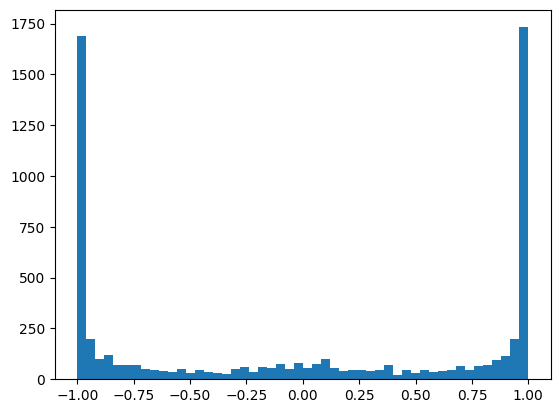

In [60]:
plt.hist(h.view(-1).tolist(),50);

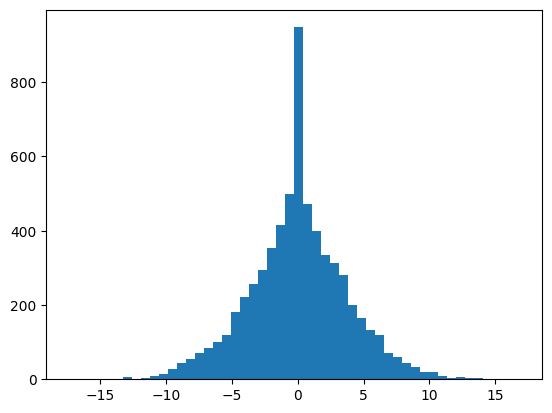

In [62]:
plt.hist(hpreact.view(-1).tolist(),50);

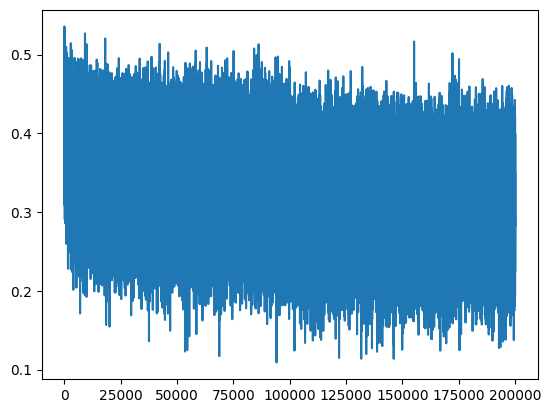

In [48]:
plt.plot(stepi,lossi)

In [49]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (xtr,ytr),
        'val': (xdev,ydev),
        'test': (xte,yte)
    }[split]
    emb = c[x] # (N,block_size, n_embd)
    embcat = emb.view(emb.shape[0],-1)
    h = torch.tanh(embcat @ w1 + b1)  # (N,n_hidden)
    logits = h @ w2 + b2 #(N,vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0717790126800537
val 2.120209217071533


In [31]:
# training split/ dev or validation split/ test split
# 80%, 10%, 10%
# training data is used to train the parameters
# validation split is used to train the hyperparameters
#    hyperparameters are like size of the embeddings, lr, number of neurons
# test split is used to test the model

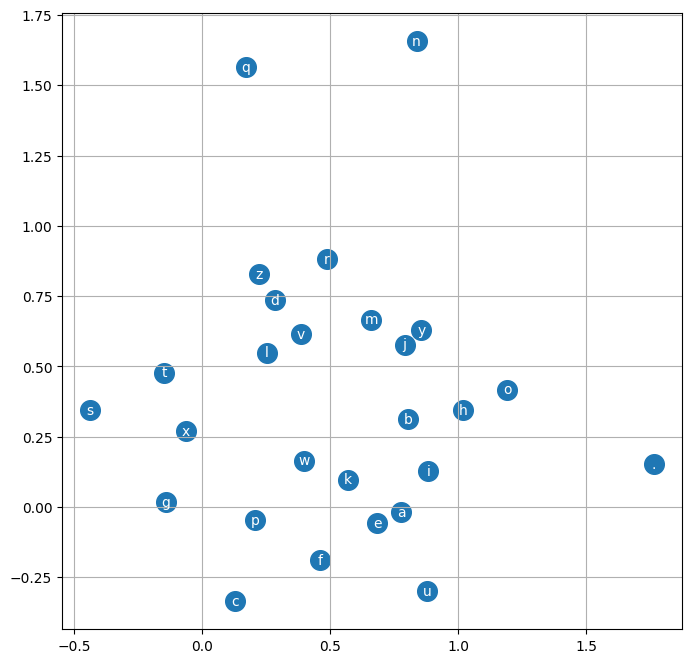

In [32]:
# visualizing the character embedding size
plt.figure(figsize=(8,8))
plt.scatter(c[:,0].data, c[:,1].data, s = 200)
for i in range(c.shape[0]):
    plt.text(c[i,0].item(), c[i,1].item(), itos[i], ha='center', va='center',color='white')
plt.grid('minor')

In [33]:
# sampling from the model
# tomorrow
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context  =  [0] * 3 #initialize with all ...
    while True:
        emb = c[torch.tensor([context])]  #(1,3(block size),d)
        h = torch.tanh(emb.view(1,-1)@w1+b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
        print(''.join(itos[i] for i in out))
    print(''.join(itos[i] for i in out)+ "\n")

m
mo
mor
mora
mora.

k
ka
kay
kaya
kayah
kayah.

s
se
see
seel
seel.

n
ni
nih
niha
nihah
nihah.

l
lo
lor
lore
loret
loreth
lorethr
lorethru
lorethruc
lorethruce
lorethrucen
lorethrucend
lorethrucendr
lorethrucendrl
lorethrucendrle
lorethrucendrleg
lorethrucendrleg.

a
ad
ade
adel
adely
adelyn
adelynn
adelynne
adelynnel
adelynneli
adelynnelin
adelynnelin.

s
sh
shy
shy.

j
je
jen
jenl
jenle
jenlei
jenleig
jenleigh
jenleigh.

e
es
esn
esna
esna.

a
ar
arl
arle
arlei
arleit
arleite
arleitel
arleitelo
arleiteloh
arleitelohe
arleitelohek
arleiteloheka
arleiteloheka.

c
ca
cay
cays
caysh
caysha
cayshab
cayshabe
cayshaber
cayshaberg
cayshaberga
cayshabergah
cayshabergahi
cayshabergahir
cayshabergahiri
cayshabergahirie
cayshabergahiriel
cayshabergahiriel.

k
ki
kin
kin.

r
re
ren
rene
renel
reneli
renelin
renelinn
renelinne
renelinnet
renelinneth
renelinnetha
renelinnethan
renelinnethana
renelinnethana.

u
ub
ube
ubel
ubell
ubelle
ubelled
ubelled.

r
ry
ryy
ryya
ryyah
ryyah.

f
fy
fye
fyeh
f